In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import os
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy as sp
import scipy.stats
path = 'C:\\Users\\user\\OneDrive\\바탕 화면\\수요예측\\train.csv'

# 1.데이터 불러오기

In [2]:
df = pd.read_csv('train.csv')
df.head() 

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,2,2,2013-01-01,0,0,0,0,a,1
2,3,2,2013-01-01,0,0,0,0,a,1
3,4,2,2013-01-01,0,0,0,0,a,1
4,5,2,2013-01-01,0,0,0,0,a,1


In [3]:
df.shape
#1017209행 9열

(1017209, 9)

In [4]:
store = pd.read_csv('store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
store.shape

(1115, 10)

# 2.데이터 합치기

In [6]:
data = df.merge(store, on = ['Store'], how = 'inner')
data.head()
#train 데이터와 store데이터를 합침.

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,2,2013-01-01,0,0,0,0,a,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,3,2013-01-02,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,4,2013-01-03,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,5,2013-01-04,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,6,2013-01-05,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [7]:
data.shape
#총 1017209행 18열

(1017209, 18)

# 3. datetime으로 변경

In [8]:
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format = True)
#자료형이 object 일 때 datetime  자료형으로 바꿔줌.

# 4.학습 데이터 만들기

In [9]:
data = data.drop_duplicates(['Date']) #중복날짜 데이터 없애기
# 중복날짜 없애면 하루단위로 2년치, 총shape(941,18)로 구성됨.

In [10]:
train_data=data.drop(columns = ['Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance',
                            'CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear',
                            'PromoInterval','DayOfWeek','Store'])
train_data
#중복날짜 없앤 train데이터

,Date,Sales,Customers,Open
0,2013-01-01,0,0,0
1,2013-01-02,5530,668,1
2,2013-01-03,4327,578,1
3,2013-01-04,4486,619,1
4,2013-01-05,4997,635,1
...,...,...,...,...
937,2015-07-27,6102,612,1
938,2015-07-28,5011,560,1
939,2015-07-29,4782,523,1
940,2015-07-30,5020,546,1


In [11]:
Sales = train_data['Sales'].values
Customers = train_data['Customers'].values
Open = train_data['Open'].values
Sales = Sales.reshape(-1,1) #정규화 해주기위해  1차원으로 1열씩 reshape 해줌(빠짐없이) = shape(Sales개수, 1)

In [12]:
train_data.columns

Index(['Date', 'Sales', 'Customers', 'Open'], dtype='object')

# 5.데이터 정규화 

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
#정규화#
scaler = MinMaxScaler()
scaler.fit(Sales)
Sales = scaler.transform(Sales)

# 6.예측데이터 나누기 

In [15]:
seq_len = 30 #한달기준인 30일을 보고 그다음날을 예측할 것임.
sequence_length = seq_len + 1 #따라서 31개씩 저장. 

result = []
for index in range(len(Sales) - sequence_length):
    result.append(Sales[index:index
                        + sequence_length])
result = np.array(result)

# 7.1 train과 test로 데이터 나누기

In [16]:
row = int(round(result.shape[0] * 0.7)) #70퍼센트를 trainset으로 나눔
train = result[:row, :] #나눈 결과를 train으로 저장.
# np.random.shuffle(train)#랜덤으로 섞음 (과적합 방지)
# train

In [17]:
x_train = train[:, :-1] 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]


x_train.shape, x_test.shape

((638, 30, 1), (273, 30, 1))

# 7.2 val데이터 나누기

In [18]:
import sklearn
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)
x_val.shape

(128, 30, 1)

In [19]:
# 데이터확인
# x_train

# 8.모델 설계 

In [20]:
import tensorflow as tf
from tensorflow.keras import layers

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(30,input_shape=(30,1),return_sequences=True))
model.add(tf.keras.layers.LSTM(30,return_sequences=False))
model.add(tf.keras.layers.Dense(1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam(0.01), 
              metrics=['mae'])

In [24]:
results = model.fit(x_train, y_train,
                    validation_data=(x_val,y_val),
                    batch_size=5,
                    epochs=60)

Epoch 1/60
102/102 [==============================] - 5s 21ms/step - loss: 0.0501 - mae: 0.1723 - val_loss: 0.0507 - val_mae: 0.1500
Epoch 2/60
102/102 [==============================] - 1s 14ms/step - loss: 0.0444 - mae: 0.1601 - val_loss: 0.0461 - val_mae: 0.1732
Epoch 3/60
102/102 [==============================] - 2s 16ms/step - loss: 0.0441 - mae: 0.1570 - val_loss: 0.0452 - val_mae: 0.1561
Epoch 4/60
102/102 [==============================] - 1s 13ms/step - loss: 0.0436 - mae: 0.1576 - val_loss: 0.0650 - val_mae: 0.1738
Epoch 5/60
102/102 [==============================] - 1s 13ms/step - loss: 0.0441 - mae: 0.1577 - val_loss: 0.0463 - val_mae: 0.1510
Epoch 6/60
102/102 [==============================] - 1s 13ms/step - loss: 0.0430 - mae: 0.1564 - val_loss: 0.0451 - val_mae: 0.1552
Epoch 7/60
102/102 [==============================] - 1s 13ms/step - loss: 0.0429 - mae: 0.1568 - val_loss: 0.0524 - val_mae: 0.1544
Epoch 8/60
102/102 [==============================] - 1s 14ms/step - 

# 9.loss 그래프 및 예측그래프 

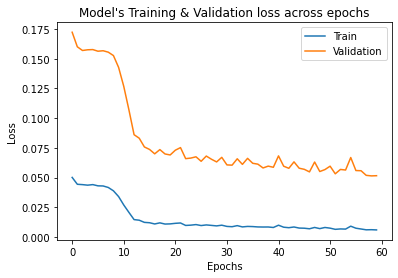

In [25]:
plt.plot(results.history['loss'])
plt.plot(results.history['mae'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

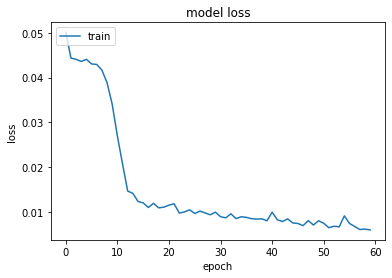

In [26]:
import matplotlib.pyplot as plt
plt.plot(results.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

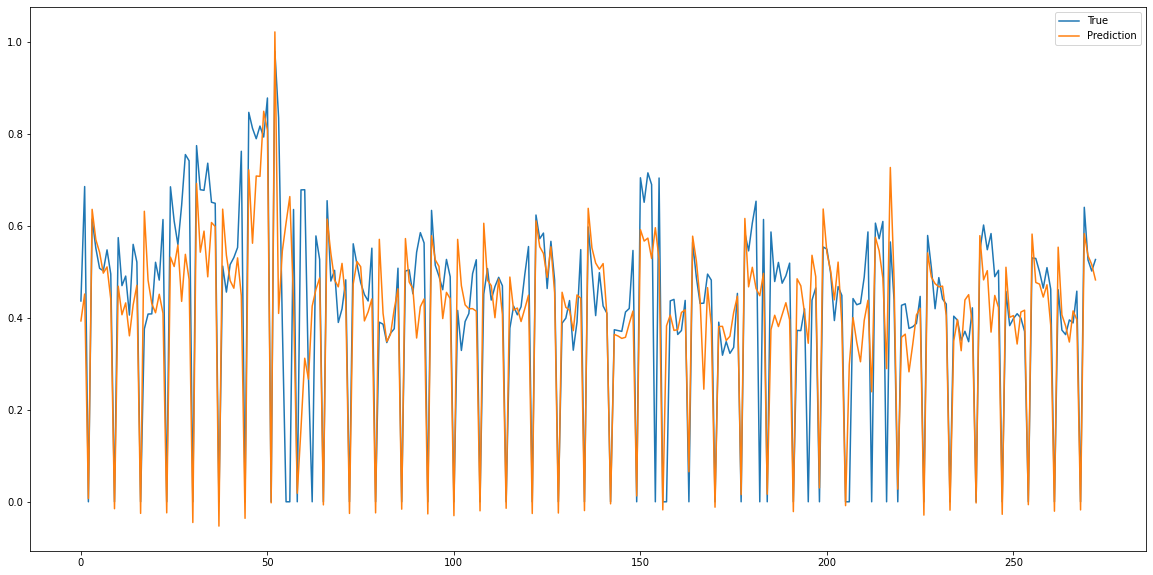

In [27]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()